In [1]:
library(tidyverse)
library(pinyin)

Warning message:
"package 'ggplot2' was built under R version 4.3.1"
Warning message:
"package 'purrr' was built under R version 4.3.1"
Warning message:
"package 'dplyr' was built under R version 4.3.1"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'pinyin' was built under R version 4.3.2"


# Coding Part

## Read Data and make it tidy

In [6]:
#From github Read
#ds <- read.csv("https://raw.githubusercontent.com/ZackYe42/STAT344-GroupProject/main/China_AQI.csv",header = T)

#From Local
ds <- read.csv("China_AQI.csv",header = T)

# Select Data
ds <- ds[,5:379]
column_means <- colMeans(ds, na.rm = T)
ds <- data.frame(AirQuality = column_means) %>% rownames_to_column(var = "city")

In [8]:
head(ds,5)

,city,AirQuality
,<chr>,<dbl>
1,北京,55.53574
2,天津,63.25470
3,石家庄,76.76514
4,唐山,64.82182
5,秦皇岛,53.41774


In [12]:
# Convert Chinese to pinyin
mypy <- pydic(method = 'toneless',dic = "pinyin2")
ps <- py(ds$city,dic = mypy)

ds1 <- ds
ds1$city <- data.frame(ps)$ps

head(ds1)
N <- nrow(ds1)
N

,city,AirQuality
,<chr>,<dbl>
1,bei_jing,55.53574
2,tian_jin,63.25470
3,shi_jia_zhuang,76.76514
4,tang_shan,64.82182
5,qin_huang_dao,53.41774
6,han_dan,82.18667


[1] 375

# Visulization

Warning message:
"Removed 31 rows containing non-finite values (`stat_boxplot()`)."


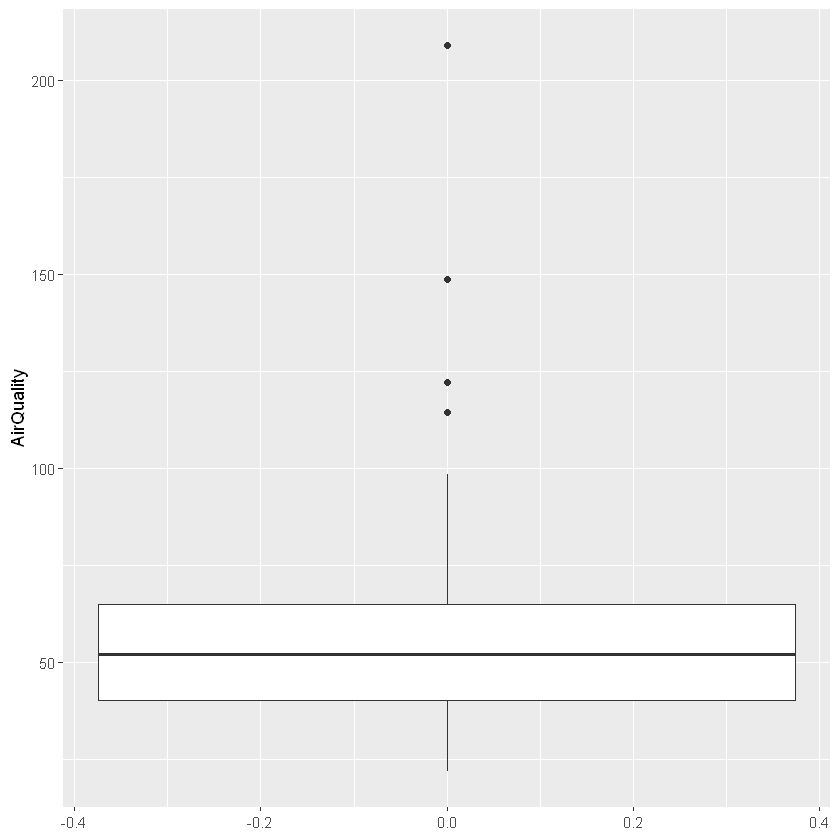

In [13]:
air_box <- ds1 %>% 
    ggplot() +
    geom_boxplot(aes(y = AirQuality))
air_box


# True Mean

In [17]:
air_mu <- mean(ds1$AirQuality,na.rm = T)
cat("The mean for chinese air quality is ", air_mu)

The mean for chinese air quality is  54.16269

## SRS Method

In [18]:
# SRS Sample 

set.seed(42)
n <- 60
srs <- sample_n(ds1,n)

In [19]:
# FPC
fpc <- (1 - n / N)

In [21]:
#Calculate Mean and SE

air_srs_mu <- mean(srs$AirQuality,na.rm = T)
air_srs_se <- sd(srs$AirQuality,na.rm = T) / sqrt(n / fpc)


cat("The mean for SRS air quality is ", air_srs_mu, ", the se for is ", air_srs_se)

The mean for SRS air quality is  57.21534 , the se for is  2.248553

# Stratified 

In [22]:
north_city <- c(
  'bei_jing', 'tian_jin', 'shi_jia_zhuang', 'tang_shan', 'qin_huang_dao',
  'han_dan', 'bao_ding', 'zhang_jia_kou', 'cheng_de', 'lang_fang',
  'cang_zhou', 'heng_shui', 'xing_tai', 'tai_yuan', 'hu_he_hao_te',
  'shen_yang', 'da_lian', 'chang_chun', 'ha_er_bin', 'xing_tai',
  'tai_yuan', 'hu_he_hao_te', 'bao_tou', 'e_er_duo_si', 'ying_kou',
  'dan_dong', 'pan_jin', 'hu_lu_dao', 'chi_feng', 'an_shan',
  'fu_shun', 'ben_xi', 'jin_zhou', 'ji_lin', 'qi_qi_ha_er',
  'mu_dan_jiang', 'da_qing', 'yan_tai', 'wei_fang', 'ji_ning',
  'tai_an', 'ri_zhao', 'wei_hai', 'dong_ying', 'zao_zhuang',
  'lin_yi', 'de_zhou', 'liao_cheng', 'bin_zhou', 'he_ze',
  'ji_nan', 'qing_dao', 'zi_bo', 'han_dan', 'xi_an',
  'tong_chuan', 'bao_ji', 'xian_yang', 'wei_nan', 'yan_an',
  'yu_lin', 'han_zhong', 'an_kang', 'shang_luo', 'jiu_quan',
  'tian_shui', 'wu_wei', 'zhang_ye', 'ping_liang', 'jiayuguan',
  'lan_zhou', 'bai_yin', 'tianshui', 'wu_wei', 'zhang_ye',
  'qing_yang', 'ding_xi', 'long_nan', 'ping_liang', 'jiu_quan',
  'jin_chang', 'shi_zui_shan', 'jiayuguan', 'yin_chuan', 'shi_zui_shan',
  'wu_zhong', 'zhong_wei', 'bao_shan', 'xi_lin_guo_le_meng', 'a_la_shan_meng',
  'wu_lu_mu_qi', 'ke_la_ma_yi', 'tu_lu_fan', 'ha_mi', 'chang_ji',
  'bo_er_ta_la', 'ba_yin_guo_leng', 'a_ke_su', 'ke_zi_le_su_ke_er_ke_zi', 'ka_shen',
  'he_tian', 'yi_li_ha_sa_ke', 'ta_cheng', 'a_le_tai', 'shi_he_zi',
  'wu_jia_qu'
)

In [23]:
north <- ds1 %>% 
    filter(city %in% north_city)

`%notin%` <- Negate(`%in%`)
south <- ds1 %>% 
    filter(city %notin% north_city)

N_nor <- nrow(north)
N_sou <- nrow(south)

w_nor <- N_nor / N
w_sou <- N_sou / N

n_nor <- round(w_nor * n,0)
n_sou <- round(w_sou * n,0)

fpc_nor <- 1 - n_nor / N
fpc_sou <- 1 - n_sou / N

In [24]:
# Stratified Sample
set.seed(42)
str_nor <- sample_n(north,n_nor)
str_sou <- sample_n(south,n_sou)

In [27]:
#Calculate Mean and SE

# Mean
air_str_n_mu <- mean(str_nor$AirQuality,na.rm = T)  
air_str_s_mu <- mean(str_sou$AirQuality,na.rm = T)  

air_str_mu <- w_nor * air_str_n_mu + w_sou * air_str_s_mu


# SE  
air_str_n_se <- sqrt(w_nor^2 * fpc_nor * var(str_nor$AirQuality,na.rm = T) / n_nor)  
air_str_s_se <- sqrt(w_sou^2 * fpc_sou * var(str_sou$AirQuality,na.rm = T) / n_sou)  
air_str_se <- sqrt(air_str_n_se^2 + air_str_s_se^2)


cat("The mean for Stratified air quality is ", air_str_mu, ", the se for is ", air_str_se)

The mean for Stratified air quality is  55.97762 , the se for is  3.617934